# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


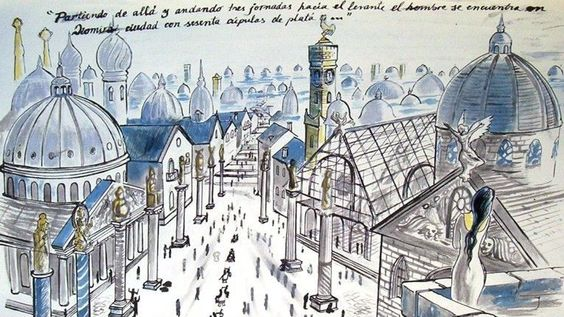

In [4]:
Image(filename='../Images/Diomira.jpg') 

## DIOMIRA notebook 

DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

### Configuration

#### Configure.py

In [7]:
import getopt

In [8]:
def cdf_to_dict(cdf):
    """
    transforms the configuration data frame into a dictionary
    """

    dc ={}
    for k in cdf.keys():
        dc[k] = cdf[k][0]
    return dc
    

def usage(program_name):
    """
    Usage of program
    """
    print("""

        Usage: python (run) {} [args]


        where args are:
         -h (--help) : this text
         -i (--info) : print a text describing the invisible city of DIOMIRA
         -d (--debug) : can be set to 'DEBUG','INFO','WARNING','ERROR'
         -c (--cfile) : full path to a configuration file
         
         example of configuration file 

         # comment line  
        Names of parameters (comma separated)
        Values of parameters (comma separated)
        
        The parameters for DIOMIRA are:

        PATH_IN = path to input DST file (must be a MCRD file)
        FILE_IN = name of input DST file
        PATH_OUT = path to output DST file (RWF file)
        FILE_OUT = name of ouput DST file (RWF file)
        FIRST_EVT,LAST_EVT,RUN_ALL,

        RUN_ALL is used to decide whether to run all the events in the file
        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (True), 
        the script will run over all elements in the DST, 
        otherwise it will exit with a warning.


        """.format(program_name))

def configure(pname,argv):


    """
    reads arguments from the command line and configures job
    """
    
    #print("argv ={}".format(argv))
    
    DEBUG='INFO'
    INFO = False
    cfile =''

    try:
        opts, args = getopt.getopt(argv, "hid:c:", ["help","info","debug","cfile"])

    except getopt.GetoptError:
        usage(pname)
        raise KeyError("An error has occured parsing getopt")

    #print("opts ={}".format(opts))

    for opt, arg in opts:
        #print("opt ={}, arg = {}".format(opt,arg))
        if opt in ("-h", "--help"):
            usage(pname)
            raise KeyError("Not really an error. Ignore")
        elif opt in ("-d", "--debug"):
            DEBUG = arg
        elif opt in ("-i", "--info"):
            INFO = True
        elif opt in ("-c", "--cfile"):
            cfile = arg
 
    lg = 'logging.'+DEBUG
    #print('INFO = {} DEBUG={}'.format(INFO,DEBUG))
    #print("lg ={}".format(lg))
    logger.setLevel(eval(lg))

    if cfile == '':
        print("Path to configuration file not given")
        usage(pname)
        raise KeyError("Please, specify your path")

    cfp =pd.read_csv(cfile,comment="#")
    # print("""
    #     Configuration parameters \n 
    #     {}
    #     """.format(cfp))

    CFP = cdf_to_dict(cfp)
    
    logger.info("ConFiguration Parameters (CFP) dictionary  = {}".format(CFP))
    return INFO, CFP
    

In [9]:
INFO, CFP = configure("DIOMIRA",['-i','-d','DEBUG','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DOROTEA_NA_ZLIB_test.csv'])

INFO:root:ConFiguration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 100, 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/', 'FILE_IN': 'WF_Na_0.h5'}


In [10]:
INFO

True

In [11]:
CFP

{'END ': 1,
 'FILE_IN': 'WF_Na_0.h5',
 'FIRST_EVT': 0,
 'LAST_EVT': 100,
 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/',
 'RUN_ALL': 1}

### Sensors response

#### SensorsResponse.py

In [12]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from FEE2 import down_scale_signal_

def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation 
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['CO12'] = FP.C12 # to be rewritten by ISIDORA
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC
    
    row.append()
    

def energy_pes(event_number, sensord):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    rdata = []

    for j in range(sensord.shape[1]):
        swf = sensord[event_number, j]
        ene = np.sum(swf)
        rdata.append(ene)
        
    return np.array(rdata) 

def simulate_sipm_response(event_number,sipmrd_):
    """
    For the moment use a dummy rutne that simply copies the sipm EARRAY
    """
    rdata = []

    for j in range(sipmrd_.shape[1]):
        logger.debug("-->SiPM number ={}".format(j))
        rdata.append(sipmrd_[event_number, j])
    return np.array(rdata)


def simulate_pmt_response(event_number,pmtrd_):
    """
    Given a MCRD signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces RWF (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT

    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        signal_daq = fee.daqSignal(signal_fee, noise_rms=0)

        rdata.append(signal_daq)
    return np.array(rdata)

def decimate_signal(event_number,pmtrd_):
    """
    Decimates the MCRD signal to produce TWF (pes, bins 25 ns)
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        twf = down_scale_signal_(pmt, int(FP.time_DAQ))
        
        
        rdata.append(twf)
    return np.array(rdata)



### DIOMIRA

#### DIOMIRA.py

In [13]:
from Nh5 import *
from Util import *
from cities import diomira
def DIOMIRA(argv):
    INFO, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        print(diomira)

    wait()
    
    print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
    FP.print_FEE()
    wait()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))

        wait()

        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib="blosc", complevel=9)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",
                           tables.Filters(0))

            # fill table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # create an extensible array to store the TWF waveforms
            pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

            #create an extensible array to store the energy in PES of PMTs 
            epmt = h5out.create_earray(h5out.root.RD, "epmt", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

            # create an extensible array to store the energy in PES of SiPMs 
            esipm = h5out.create_earray(h5out.root.RD, "esipm", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM), 
                                    expectedrows=NEVENTS_DST)

            
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)
                
                #TWF
                 
                truePMT = decimate_signal(i,pmtrd_)
                
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                
                #TWF for pmts
                pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

                #fill ene_pmt vector
                enePMT = energy_pes(i, pmtrd_)
                #append to epmt EARRAY
                epmt.append(enePMT.reshape(1, NPMT))

                #fill ene_sipm vector
                eneSIPM = energy_pes(i, sipmrd_)
                esipm.append(eneSIPM.reshape(1, NSIPM))

            pmtrwf.flush()
            pmttwf.flush()
            sipmrwf.flush()
            epmt.flush()
            esipm.flush()


    print("Leaving Diomira. Safe travels!")


### Configuration file

In [14]:
!less ../Config/DIOMIRA_NA_ZLIB_test.csv

# Configuration file for DIOMIRA
# The parameters for DIOMIRA are:
#
#        PATH_IN = path to input DST file (must be a MCRD file)
#        FILE_IN = name of input DST file
#        PATH_OUT = path to output DST file (RWF file)
#        FILE_OUT = name of ouput DST file (RWF file)
#        FIRST_EVT,LAST_EVT,RUN_ALL,
#
#        RUN_ALL is used to decide whether to run all the events in the file
#        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
#        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (T rue), 
#        the script will run over all elements in the DST, 
#        otherwise it will exit with a warning.
#
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END 
/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/,/Use rs/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/,WF_Na_1Kevts_c omp1_chunk32k.h5,WF_Na_test_RWF.h5,0,5,1,1
(END)

####  DIOMIRA main

In [15]:
DIOMIRA(["DIOMIRA",'-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:ConFiguration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 5, 'FILE_OUT': 'WF_Na_test_RWF.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}

Leaving there and proceeding for three days toward the east, you reach Diomira, 
a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, 
a crystal theater, a golden cock that crows every morning on a tower. 
All these beauties will already be familiar to the visitor, 
who has seen them also in other cities. 
But the special quality of this city for the man who arrives there on a September evening, 
when the days are growing shorter 
and the multicolored lamps are lighted all at once at the doors of the food stalls 
and from a terrace a woman's voice cries ooh!, is that he feels envy 
toward th

### Checking the file

In [17]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5'

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5


In [18]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+") 

In [19]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Col(s

In [20]:
pmttwf = h5f.root.RD.pmttwf

In [21]:
pmttwf

/RD/pmttwf (EArray(5, 12, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 24000)

In [22]:
pmt0 = pmttwf[0,0]

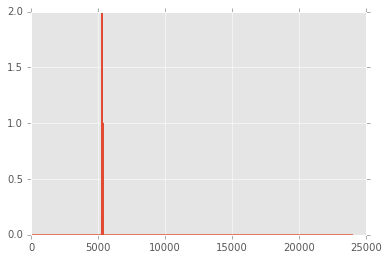

In [23]:
plt.plot(pmt0)

In [24]:
pmtrwf = h5f.root.RD.pmtrwf

In [25]:
pmtr0 = pmtrwf[0,0]

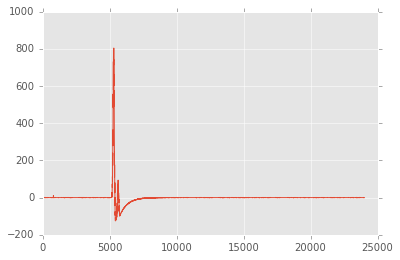

In [26]:
plt.plot(pmtr0)

In [27]:
pmt0_zs = [x for x in pmt0 if x != 0]

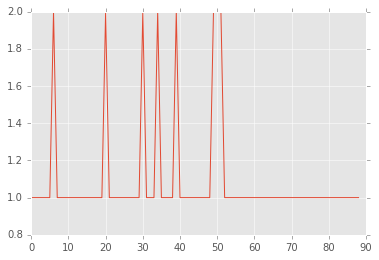

In [28]:
plt.plot(pmt0_zs)

##### The effect of decimation is very clear in the plot above

### Plotting waveforms

In [29]:
from PlotUtil import *

In [30]:
def plot_waveforms(pmtwfdf, maxlen=0):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmtwfdf[0])
    
    if maxlen > 0:
        len_pmt = maxlen
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='samples', ylabel='adc')
        plt.plot(pmtwfdf[i])

    
    plt.show()

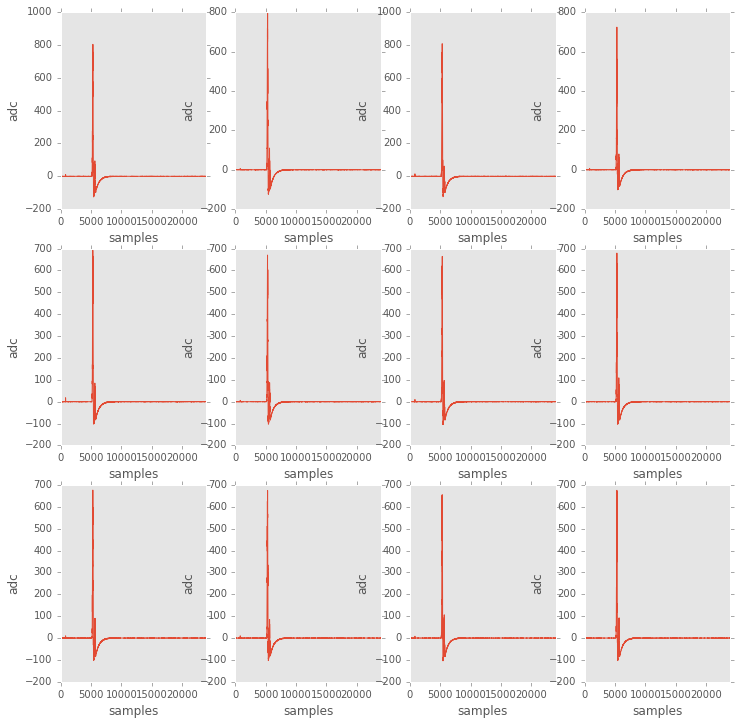

In [31]:
plot_waveforms(pmtrwf[0]) 

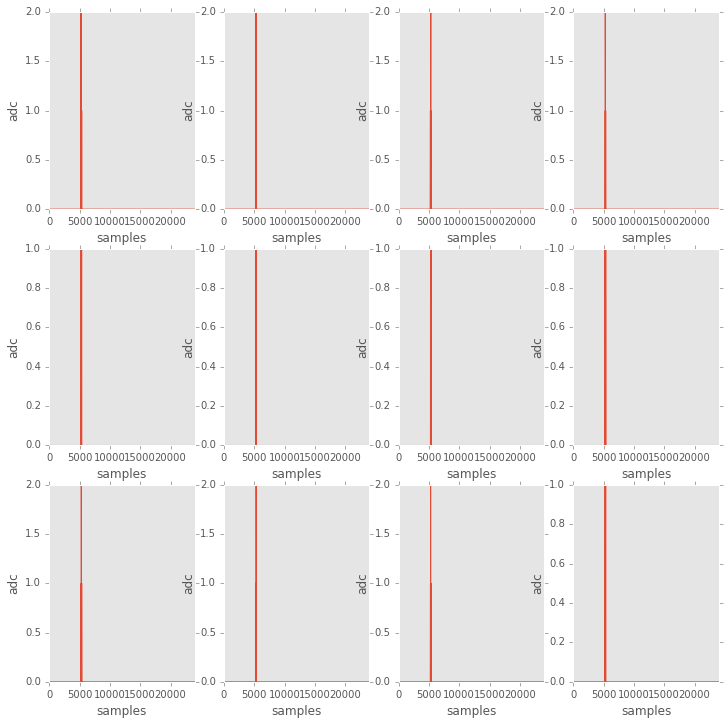

In [32]:
plot_waveforms(pmttwf[0]) 

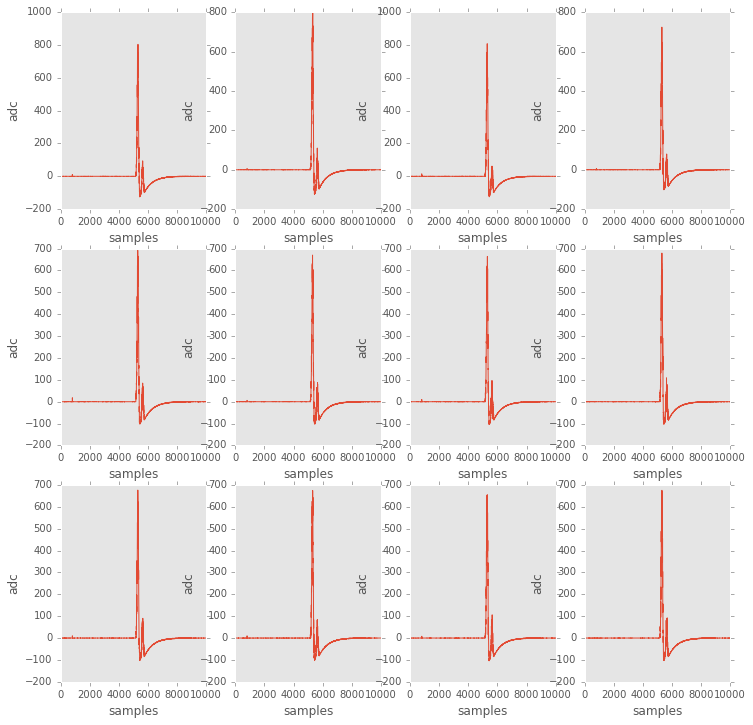

In [33]:
plot_waveforms(pmtrwf[0], maxlen=10000) 

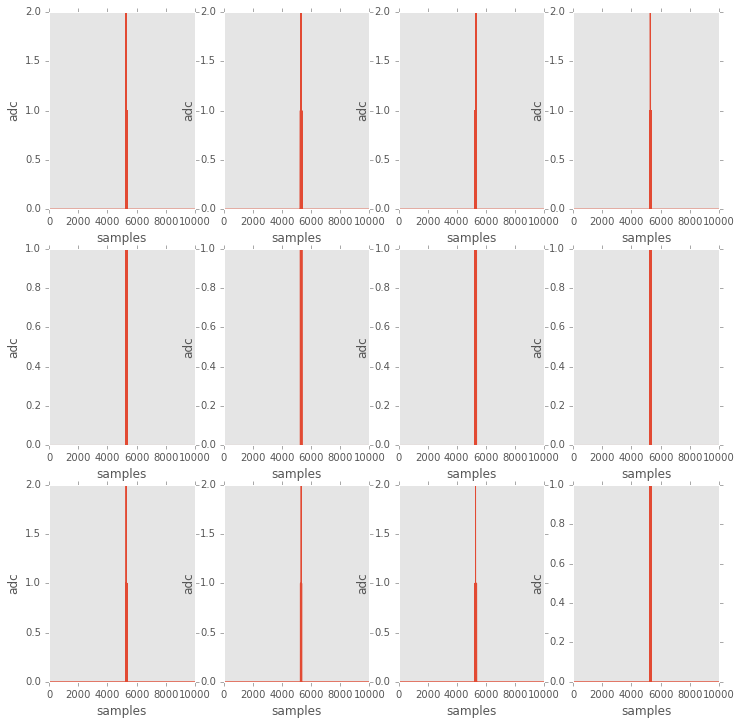

In [34]:
plot_waveforms(pmttwf[0], maxlen=10000) 

### Running Script

In [35]:
ls

DIOMIRA.ipynb                PMT_parameterization.ipynb
Dorothea.ipynb               PandasDST.ipynb
IC.ipynb                     PlotUtil.ipynb
ISIDORA.ipynb                SIERPE.ipynb
ItsAKindOfMagic.ipynb        SiPM_parameterization.ipynb
NDM.ipynb                    SiPMresp_MC.ipynb
Nh5-Event-Model.ipynb        Utilities.ipynb
NotesAndTips.ipynb


In [36]:
!less ../Config/DIOMIRA_NA_ZLIB.csv

# Configuration file for DIOMIRA
# The parameters for DIOMIRA are:
#
#        PATH_IN = path to input DST file (must be a MCRD file)
#        FILE_IN = name of input DST file
#        PATH_OUT = path to output DST file (RWF file)
#        FILE_OUT = name of ouput DST file (RWF file)
#        FIRST_EVT,LAST_EVT,RUN_ALL,
#
#        RUN_ALL is used to decide whether to run all the events in the file
#        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
#        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (T rue), 
#        the script will run over all elements in the DST, 
#        otherwise it will exit with a warning.
#
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END 
/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/,/Use rs/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/,WF_Na_1Kevts_c omp1_chunk32k.h5,WF_Na_1k.h5,0,1000,1,1
(END)

In [37]:
%time %run ../Cities/DIOMIRA.py -c ../Config/DIOMIRA_NA_ZLIB.csv

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 1000, 'FILE_OUT': 'WF_Na_1k.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}
Press a key...

        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FE

The execution time when the input file has been compressed with BLOSC is 1min 24s for 99 events thus less than 1s per event.

### File Structure

In [39]:
h5out = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5', "r+") 

In [40]:
h5out

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Col(shape=(

### Space in disk

In [41]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5'

-rw-r--r--  1 jjgomezcadenas  staff   126M Aug 24 20:23 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5


In [42]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/WF_Na_1Kevts_comp1_chunk32k.h5'

-rw-r--r--@ 1 jjgomezcadenas  staff   232M Aug 14 20:31 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/WF_Na_1Kevts_comp1_chunk32k.h5
